In [1]:
import sys
import random
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import json
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig
from sklearn.model_selection import train_test_split
import argparse

In [2]:
name_of_model = 'Name'
blocks_unfrozen = 1
base_block_lr = 0.001
regression_block_lr = 0.01
HLA = 'HLAA0201'
encoding = 'epitope'

In [3]:
device = 'cpu'

In [4]:
#########################################################
# Model Definition: ESMCMasked
#########################################################
class ESMCMasked(nn.Module):
    """
    A wrapper that takes a pre-trained ESM C model and adds
    a masking (language modeling) head on top of the final hidden states.
    This version expects batched input_ids and attention_mask in forward.
    """
    def __init__(self, base_model, hidden_dim=960, num_aa=33):
        super().__init__()
        self.base_model = base_model  # Pretrained ESM C model
        self.mask_head = nn.Linear(hidden_dim, num_aa)  # Simple linear LM head

    def forward(self, input_ids, attention_mask=None):
        """
        Args:
          input_ids: [batch_size, seq_len] integer tokens
          attention_mask: [batch_size, seq_len], 1 for real tokens, 0 for padding
        Returns:
          out_logits: [batch_size, seq_len, num_aa]
        """
        # 1) ESM forward
        #    If your ESM model supports input_ids directly (like a HuggingFace model),
        #    do something like:
        outputs = self.base_model.forward(input_ids )
        # outputs.hidden_states[-1]: [batch_size, seq_len, hidden_dim]
        hidden_states = outputs.hidden_states[-1].to(torch.float32) # ensure float32

        # 2) Pass through the custom LM head
        out_logits = self.mask_head(hidden_states)  # [batch_size, seq_len, num_aa]
        return out_logits

##################################################
# 3. Load the base ESM C model and wrap it
##################################################
print("Loading pretrained ESM_Cambrian model...", flush = True)
base_model = ESMC.from_pretrained("esmc_300m").to(device)

# Create our extended masked model
model_masked = ESMCMasked(base_model, hidden_dim=960, num_aa=33).to(device)

def load_model(model_path, device='cpu'):
    # Load checkpoint
    checkpoint = torch.load(model_path, map_location=device)
    config = checkpoint['config']
    
    # 1. Load base ESMC model
    base_model = ESMC.from_pretrained("esmc_300m").to(device)
    
    # 3. Wrap with ESMCMasked using saved config
    model = ESMBA(
        base_model,
    ).to(device)
    
    # 4. Load trained weights
    state_dict = checkpoint['model_state_dict']

    # Remove keys corresponding to the old mask head
    state_dict = {k: v for k, v in state_dict.items()}
    
    model.load_state_dict(state_dict, strict=False)
    
    return model


# if not torch.cuda.is_available():
#     print("CUDA is not available. Exiting.")
#     sys.exit(1)

device = torch.device("cpu")
print(f"Using device: {device}", flush=True)

full_pretraining = False  # Simplified boolean conversion
name_of_model = "RUN2"
encoding = 'epitope'
# file_path = '/global/scratch/users/sergiomar10/models/esm_c/masking/HLA-0201_epitope_only/False-Full_pretraining_2000_seq_AUG_3.pt'
file_path = '/global/scratch/users/sergiomar10/models/esm_c/masking/ALLHLAs_epitope_only/False-Full_pretraining_100000_seq_AUG_3_ALL_HLAS.pt'

# model = load_model(
#     file_path,  # Must match training setting!
#     device=device
# )

# base_model = model.base_model

Loading pretrained ESM_Cambrian model...


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

Using device: cpu


In [5]:
from torch.utils.data import Dataset, DataLoader
import numpy as np
num_augmentations = 1

#########################################################
# FASTA Parser
#########################################################
def parse_fasta(file_path):
    sequences = []
    with open(file_path, 'r') as f:
        header = None
        seq = ""
        for line in f:
            line = line.strip()
            if line.startswith(">"):
                if seq:
                    sequences.append((header, seq))
                    seq = ""
                header = line[1:]
            else:
                seq += line
        if seq:
            sequences.append((header, seq))
    return sequences

#########################################################
# Load + Filter Data
#########################################################
train_fasta_path = "/global/scratch/users/sergiomar10/jupyter_notebooks/hla_protein_sequences.fasta"
all_data = parse_fasta(train_fasta_path)

hla_and_epitopes = []
for head, hla_seq in all_data:
    # Parse out the HLA naming from header
    head = head.split('|')[1][:7].replace('*', '').replace(':', '')
    head = 'HLA' + head
    if head != HLA:
        continue

    # Load the CSV for that HLA
    iedb_path = f"/global/scratch/users/sergiomar10/data/IEDB_SQL/IEDB_{head}_final.csv"
    df = pd.read_csv(iedb_path, header=None)
    df.columns = [
        'sequence', 'ref_ID', 'submissionID', 'Epitope_ID', 'protein_origin',
        'ID_SOURCE', "SOURCE_ORGANISM", "IC50_nM", "DESCRIPTION_BINDING", "Year_submission"
    ]
    # Filter to "Positive" sequences
    df = df[df['DESCRIPTION_BINDING'].str.contains("Positive")][["ref_ID","sequence"]].values

    for ref_id, epitope in df:
        if any(x in epitope for x in ['+', '(', 'X']):
            continue
        # If your encoding mode = 'HLA', prepend the HLA sequence to epitope
        if encoding == 'HLA':
            epitope = hla_seq + epitope

        hla_and_epitopes.append(epitope)

hla_and_epitopes = np.unique(hla_and_epitopes)

max_length = np.max([len(x) for x in hla_and_epitopes])

random.shuffle(hla_and_epitopes)
print(f"Filtered {len(hla_and_epitopes)} sequences for training.", flush=True)

train_seqs, temp_seqs = train_test_split(hla_and_epitopes, test_size=0.2, random_state=42)
val_seqs, eval_seqs = train_test_split(temp_seqs, test_size=0.5, random_state=42)

print(f"Data split: {len(train_seqs)} train, {len(val_seqs)} val, {len(eval_seqs)} eval.", flush=True)

# Now, apply augmentation only to the training set
augmented_train_seqs = []
for seq in train_seqs:
    for _ in range(num_augmentations):
        augmented_train_seqs.append(seq)

print(f"After augmentation: {len(augmented_train_seqs)} training sequences.", flush=True)


print(
    f"Data split: {len(train_seqs)} train, "
    f"{len(val_seqs)} val, {len(eval_seqs)} eval.",
    flush=True
)

#########################################################
# Masked LM Dataset
#########################################################
class MaskedProteinDataset(Dataset):
    def __init__(self, sequences, base_model, mlm_probability=0.15, max_length=15):
        self.sequences = sequences
        self.tokenizer = base_model.tokenizer
        self.mlm_probability = mlm_probability
        self.max_length = max_length
        self.pad_id = self.tokenizer.pad_token_id  # e.g. 1
        self.mask_id = self.tokenizer.mask_token_id  # e.g. 32

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        # 1) Tokenize the entire sequence up to self.max_length
        encoding = self.tokenizer(
            seq,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=self.max_length
        )
        input_ids = encoding['input_ids'].squeeze(0)        # shape [seq_len]
        attention_mask = encoding['attention_mask'].squeeze(0)  # shape [seq_len]

        # 2) Mask only the last 11 real tokens
        masked_input_ids, labels = self.mask_tokens(input_ids)

        # Return everything, along with the raw sequence if needed
        return masked_input_ids, attention_mask, labels, seq

    def mask_tokens(self, input_ids):
        """
        Masks tokens ONLY within the last 11 real (non-pad) positions.
        All other positions remain unmasked.
        """
        # Initialize labels to pad_id (which we'll ignore in the loss)
        labels = torch.full_like(input_ids, self.pad_id)

        # Identify all non-pad token positions
        nonpad_positions = (input_ids != self.pad_id).nonzero(as_tuple=True)[0]
        if len(nonpad_positions) == 0:
            # Edge case: if there's nothing but padding, just return as-is
            return input_ids, labels

        # We'll only allow masking within the last 11 real tokens
        # e.g., if we have 15 real tokens, we choose positions [-11:].
        # if we have fewer than 11 real tokens, then it's effectively "mask up to length"
        maskable_positions = nonpad_positions[-11:]  # slice last 11 indices

        # Create a probability vector of 0 for all tokens, except for these last 11 real ones
        probs = torch.zeros_like(input_ids, dtype=torch.float)
        probs[maskable_positions] = self.mlm_probability  # mlm_probability only for last 11

        # Decide which of those positions to actually mask
        masked_indices = torch.bernoulli(probs).bool()

        # Copy the original token IDs into 'labels' only where we do mask
        labels[masked_indices] = input_ids[masked_indices]
        # Replace masked positions in input_ids with <mask> 
        input_ids[masked_indices] = self.mask_id

        return input_ids, labels


def collate_fn(batch):
    """
    batch is a list of tuples:
        (masked_input_ids, attention_mask, labels, raw_sequence)
    """
    input_ids_list, attn_masks_list, labels_list, raw_seqs_list = zip(*batch)

    input_ids = torch.stack(input_ids_list, dim=0)
    attention_mask = torch.stack(attn_masks_list, dim=0)
    labels = torch.stack(labels_list, dim=0)

    # raw_seqs_list is a tuple of strings (the raw epitopes), so just keep it as a list
    return input_ids, attention_mask, labels, list(raw_seqs_list)


def get_mlm_dataloader(sequences, base_model, batch_size=8, shuffle=True, max_length=15):
    dataset = MaskedProteinDataset(
        sequences,
        base_model,
        mlm_probability=0.15,
        max_length=max_length
    )
    loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=collate_fn
    )
    return loader

#########################################################
# Create DataLoaders
#########################################################

base_model = model_masked.base_model

batch_size = 8
train_loader = get_mlm_dataloader(train_seqs, base_model, batch_size=batch_size, shuffle=True, max_length=max_length)
val_loader   = get_mlm_dataloader(val_seqs,   base_model, batch_size=batch_size, shuffle=False, max_length=max_length)
eval_loader  = get_mlm_dataloader(eval_seqs,  base_model, batch_size=batch_size, shuffle=False, max_length=max_length)

Filtered 6576 sequences for training.
Data split: 5260 train, 658 val, 658 eval.
After augmentation: 5260 training sequences.
Data split: 5260 train, 658 val, 658 eval.


In [6]:
#########################################################
# Training and Validation Loops
#########################################################
num_epochs = 10

# Simple function to measure MLM accuracy on masked positions
def evaluate_mlm_accuracy(loader):
    """Compute how often the model guesses the correct token for the masked tokens."""
    model_masked.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for input_ids, attention_mask, labels, _ in loader:
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            labels = labels.to(device)

            # Forward
            logits = base_model(input_ids, attention_mask)  # [batch_size, seq_len, vocab_size]
            # We only compare at positions where labels != -100
            mask_positions = (labels != 1)
            if not mask_positions.any():
                continue

            # Predictions
            preds = torch.argmax(logits, dim=-1)  # [batch_size, seq_len]
            correct += (preds[mask_positions] == labels[mask_positions]).sum().item()
            total += mask_positions.sum().item()

    model_masked.train()
    return correct / total if total > 0 else 0.0

In [7]:
import math

model_masked.eval()
eval_results = []
total_nll = 0.0
total_tokens = 0

with torch.no_grad():
    for input_ids, attention_mask, labels, raw_epitopes in eval_loader:
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        labels = labels.to(device)

        logits = base_model(input_ids, attention_mask)
        logits = logits.sequence_logits
        
        # Compute softmax probabilities and log probabilities
        probs = F.softmax(logits, dim=-1)
        log_probs = F.log_softmax(logits, dim=-1)
        preds = torch.argmax(probs, dim=-1)

        for b in range(input_ids.size(0)):
            # Grab the actual epitope string for this sample
            epitope_seq = raw_epitopes[b]

            # Identify valid positions (for example, positions that are not padding; here, labels[b]!=1)
            valid_positions = torch.where(labels[b] != 1)[0]
            
            for pos in valid_positions:
                pos = pos.item()
                original_id = labels[b, pos].item()
                pred_id = preds[b, pos].item()
                pred_prob = probs[b, pos, pred_id].item()

                # Compute the negative log likelihood for this token and its perplexity
                token_log_prob = log_probs[b, pos, original_id]
                token_nll = -token_log_prob.item()
                token_perplexity = math.exp(token_nll)

                total_nll += token_nll
                total_tokens += 1

                original_aa = base_model.tokenizer.decode([original_id]).strip()
                predicted_aa = base_model.tokenizer.decode([pred_id]).strip()

                eval_results.append({
                    "batch_index": b,
                    "epitope": epitope_seq,
                    "position": pos,
                    "original_aa": original_aa,
                    "predicted_aa": predicted_aa,
                    "predicted_prob": pred_prob,
                    "token_perplexity": token_perplexity  # Per-token perplexity
                })

# # Compute global perplexity over all valid tokens
# if total_tokens > 0:
#     avg_nll = total_nll / total_tokens
#     global_perplexity = math.exp(avg_nll)
# else:
#     global_perplexity = float('inf')

# print(f"Global Perplexity: {global_perplexity:.4f}")

# # Save evaluation predictions to CSV
# eval_df = pd.DataFrame(eval_results)
# eval_save_dir = "/global/scratch/users/sergiomar10/data/ESMC_Pretrain"
# os.makedirs(eval_save_dir, exist_ok=True)
# eval_csv_path = os.path.join(eval_save_dir, f"{name_of_model}.csv")
# eval_df.to_csv(eval_csv_path, index=False)
# print(f"Evaluation predictions saved to {eval_csv_path}", flush=True)


In [8]:
eval_df = pd.DataFrame(eval_results)

In [9]:
eval_df['length'] = eval_df['epitope'].apply(len)

In [10]:
eval_df.loc[:, ['length', 'predicted_prob']].groupby('length').min().reset_index()

,length,predicted_prob
0,8,0.104474
1,9,0.079255
2,10,0.081328
3,11,0.094776
4,12,0.087491
5,16,0.099257
6,20,0.103440


In [15]:
from collections import Counter
Counter(eval_df['length'])

Counter({9: 780, 10: 317, 11: 10, 16: 5, 8: 5, 12: 2, 20: 1})

<Axes: >

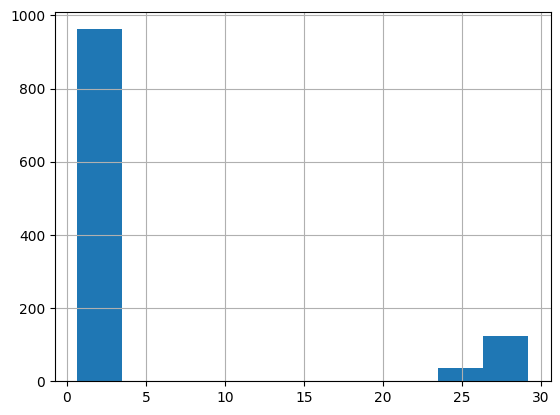

In [12]:
np.log10(eval_df['token_perplexity']).hist()